In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import (
                               RandomForestRegressor,
                               BaggingRegressor
                              )
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('Clean_Dataset.csv', index_col=0)

In [3]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Что такое ансамбли:
https://habr.com/ru/articles/955110/

# EDA

In [4]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [5]:
for col in df.columns:
    print(f"for column : {col}\n")
    print(df[col].value_counts())

for column : airline

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64
for column : flight

UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: flight, Length: 1561, dtype: int64
for column : source_city

Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64
for column : departure_time

Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: departure_time, dtype: int64
for column : stops

one            250863
zero            36004
two_or_more     13286
Name: stops, dtype: int64
for column : arrival_time

Night            91538
Evening          78323
Morning          62735
Afternoon 

In [6]:
df.dropna(subset=['price'], inplace=True)

Text(0.5, 1.0, 'Цены бизнеса')

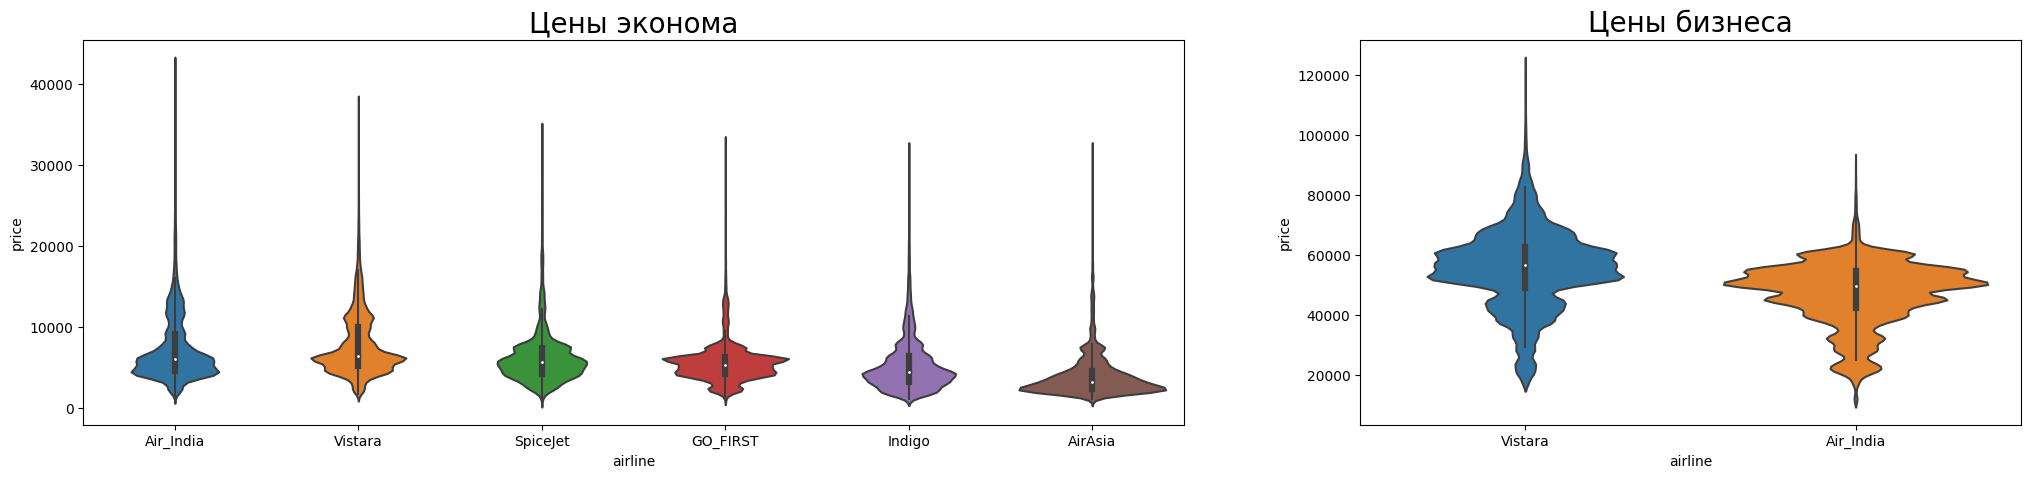

In [7]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), kind="boxen", ax=axs[0])
axs[0].set_title("Цены эконома",fontsize=20)
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), kind="boxen", ax=axs[1])
axs[1].set_title("Цены бизнеса",fontsize=20)

<AxesSubplot: xlabel='days_left', ylabel='price'>

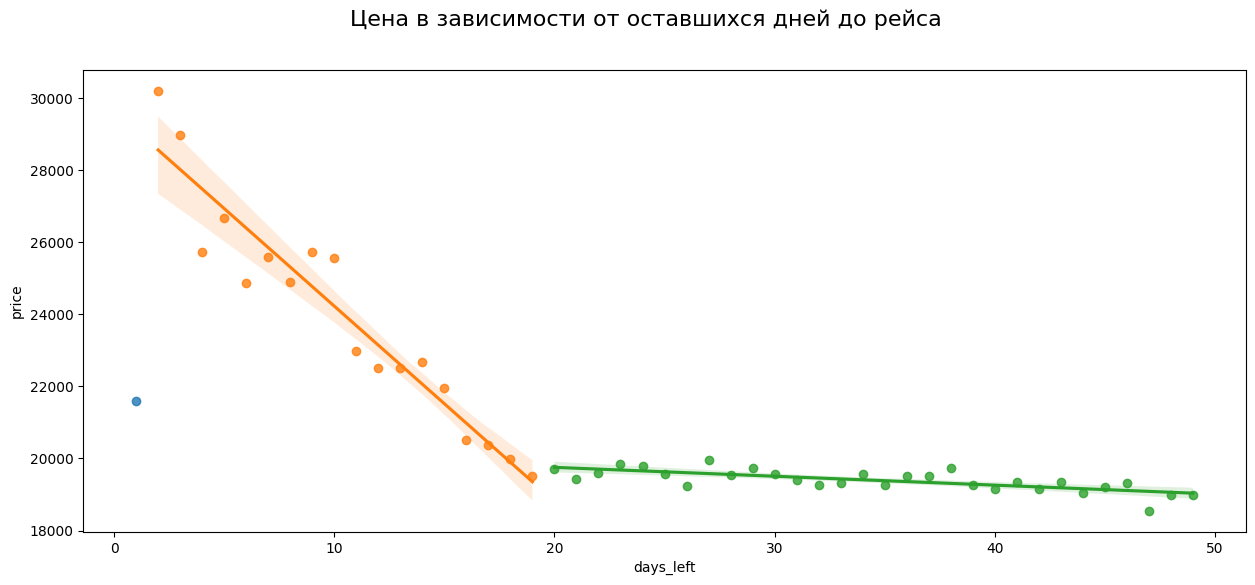

In [8]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()
plt.figure(figsize=(15,6)).suptitle('Цена в зависимости от оставшихся дней до рейса', fontsize=16)
ax = plt.axes()
sns.regplot(x=df_temp.loc[df_temp["days_left"]==1].days_left, y=df_temp.loc[df_temp["days_left"]==1].price, fit_reg=False, ax=ax)
sns.regplot(x=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].days_left, y=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].price, fit_reg=True, ax=ax)
sns.regplot(x=df_temp.loc[df_temp["days_left"]>=20].days_left, y=df_temp.loc[df_temp["days_left"]>=20].price, fit_reg=True, ax=ax)

Text(0.5, 1.0, 'Время прибытия')

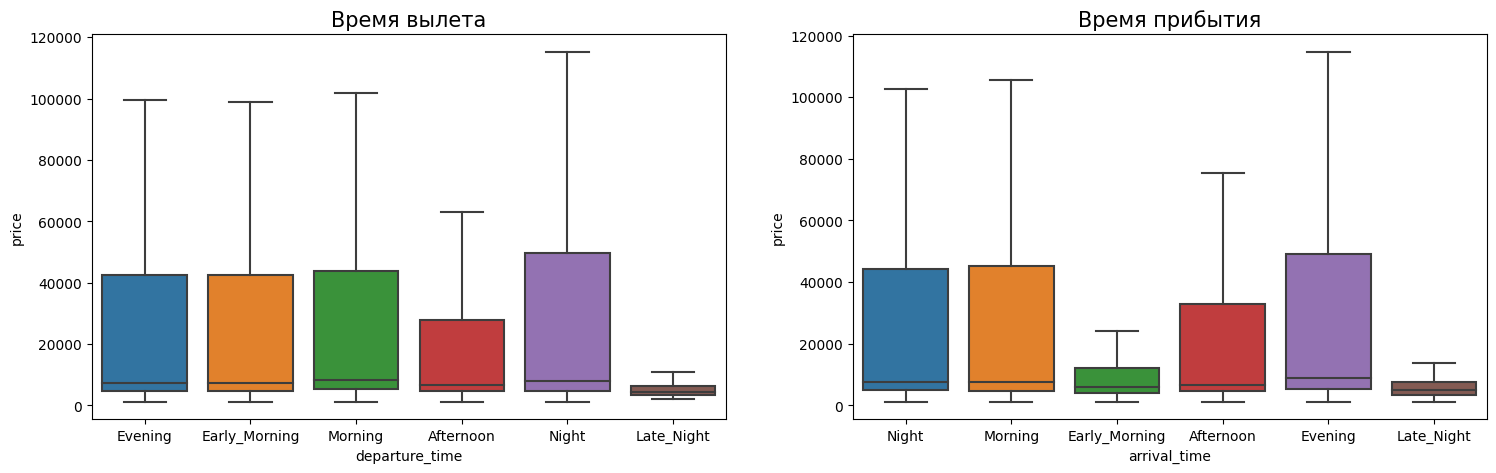

In [9]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.boxplot(data=df, y="price", x="departure_time",showfliers=False).set_title("Время вылета",fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(data=df, y="price", x="arrival_time",showfliers=False).set_title("Время прибытия",fontsize=15)

In [10]:
le = LabelEncoder() # onehot - плохо для деревьев, binaryencoding

cat_cols = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

df_orginal = df.copy()

# Apply label encoding to the specified columns
df[cat_cols] = df[cat_cols].apply(le.fit_transform)


# Display unique encoded values for each categorical column for Data Preprocessing in the Model deployment stage.
for column in cat_cols:
    unique_encoded_values = df[column].unique()   
    print(f"Unique encoded values for column '{column}' {df_orginal[column].unique()} : {unique_encoded_values}")

Unique encoded values for column 'airline' ['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India'] : [4 0 5 2 3 1]
Unique encoded values for column 'flight' ['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433'] : [1408 1387 1213 ...  558  587  718]
Unique encoded values for column 'source_city' ['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai'] : [2 5 0 4 3 1]
Unique encoded values for column 'departure_time' ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night'] : [2 1 4 0 5 3]
Unique encoded values for column 'stops' ['zero' 'one' 'two_or_more'] : [2 0 1]
Unique encoded values for column 'arrival_time' ['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night'] : [5 4 1 0 2 3]
Unique encoded values for column 'destination_city' ['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi'] : [5 0 4 3 1 2]
Unique encoded values for column 'class' ['Economy' 'Business'] : [1 0]


In [11]:
encoding_map = {value: idx for idx, value in enumerate(df['airline'].unique())}
df['airline'] = df['airline'].replace(encoding_map)

In [12]:
df.dtypes

airline               int64
flight                int64
source_city           int64
departure_time        int64
stops                 int64
arrival_time          int64
destination_city      int64
class                 int64
duration            float64
days_left             int64
price                 int64
dtype: object

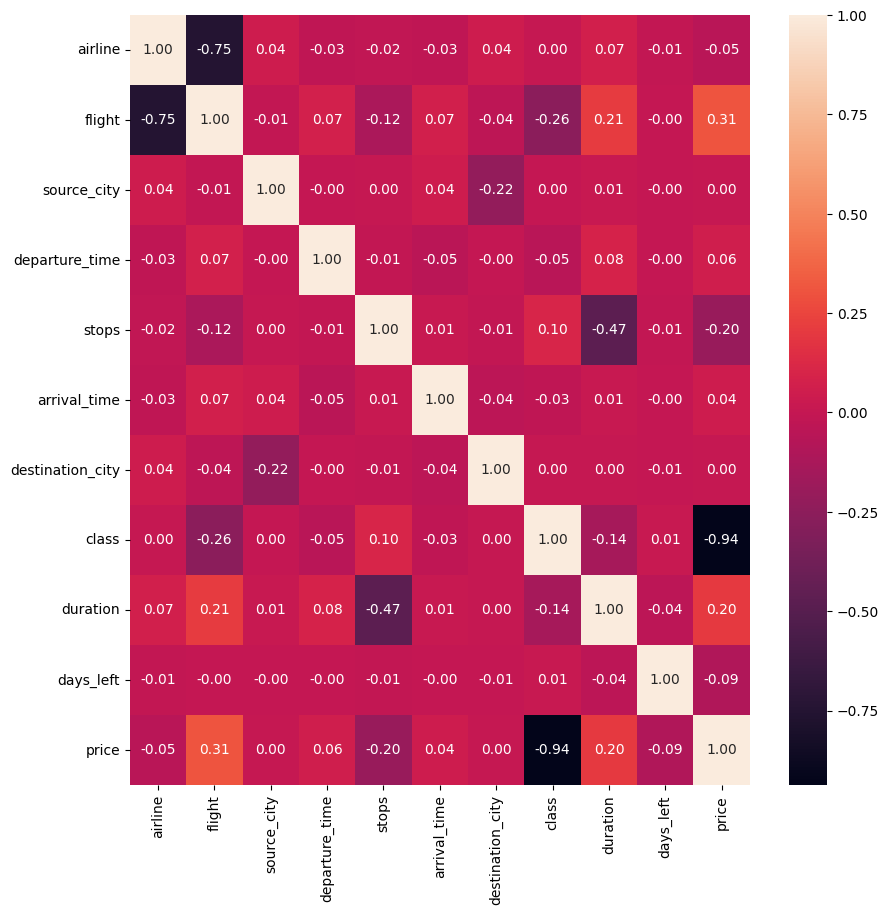

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True, fmt=".2f")
plt.show()

In [14]:
df = df.drop(columns=['flight'])

In [15]:
X, y = df.drop(columns=["price"]), df["price"]

num_features_to_select = 6 
selected_features = SelectKBest(f_regression, k=num_features_to_select).fit(X, y)

# Get the indices of the selected features
selected_feature_indices = selected_features.get_support(indices=True)

selected_feature_names = X.columns[selected_feature_indices]
print("Selected features:", selected_feature_names)


Selected features: Index(['airline', 'departure_time', 'stops', 'class', 'duration', 'days_left'], dtype='object')


In [16]:
selected = X[selected_feature_names]

In [17]:
selected.head()

,airline,departure_time,stops,class,duration,days_left
0,0,2,2,1,2.17,1
1,0,1,2,1,2.33,1
2,1,1,2,1,2.17,1
3,2,4,2,1,2.25,1
4,2,4,2,1,2.33,1


In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))

num_cols = ['duration', 'days_left']

selected[num_cols] = scaler.fit_transform(selected[num_cols])

/var/folders/9g/_5ffyp2n731d2wgcprc6zswh0000gn/T/ipykernel_48695/706539818.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected[num_cols] = scaler.fit_transform(selected[num_cols])


In [19]:
selected.head()

,airline,departure_time,stops,class,duration,days_left
0,0,2,2,1,0.027347,0.0
1,0,1,2,1,0.030612,0.0
2,1,1,2,1,0.027347,0.0
3,2,4,2,1,0.028980,0.0
4,2,4,2,1,0.030612,0.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(selected, y, test_size = 0.2, random_state = 42)

# Linear

In [21]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [22]:
model.coef_

array([  -865.98138026,     53.46931148,  -3329.34961057, -45219.49610361,
         4697.53325861,  -6402.13227583])

In [23]:
y_pred = model.predict(X_test)

In [24]:
test_mse = mean_squared_error(y_test, y_pred)

test_r2 = r2_score(y_test, y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred)

In [25]:
print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')
print(f'Test MAPE: {test_mape}')

Test MSE: 50728287.093552046
Test R2: 0.9015906274674752
Test MAPE: 0.456930190682247


# Bagging

In [26]:
bagging = BaggingRegressor(n_estimators=50) 
bagging.fit(X_train, y_train) 

BaggingRegressor(n_estimators=50)

In [27]:
y_pred = bagging.predict(X_test)

In [28]:
test_mse = mean_squared_error(y_test, y_pred)

test_r2 = r2_score(y_test, y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred)

In [29]:
print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')
print(f'Test MAPE: {test_mape}')

Test MSE: 26554414.257815145
Test R2: 0.9484862707810121
Test MAPE: 0.17300184462690044


# RandomForest

In [30]:
forest = RandomForestRegressor(n_estimators=50, random_state=42) 
forest.fit(X_train, y_train) 


RandomForestRegressor(n_estimators=50, random_state=42)

In [31]:
forest.feature_names_in_

array(['airline', 'departure_time', 'stops', 'class', 'duration',
       'days_left'], dtype=object)

In [32]:
forest.feature_importances_

array([0.01079435, 0.00562297, 0.0019364 , 0.89004743, 0.06818264,
       0.02341621])

In [33]:
y_pred = forest.predict(X_test)

In [34]:
test_mse = mean_squared_error(y_test, y_pred)

test_r2 = r2_score(y_test, y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred)

In [35]:
print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')
print(f'Test MAPE: {test_mape}')

Test MSE: 26556345.114318717
Test R2: 0.9484825250527833
Test MAPE: 0.17285336522593772


# Boosting

In [36]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [37]:
from xgboost import XGBRegressor


boosting = XGBRegressor(n_estimators=100, learning_rate=0.1)
boosting.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
boosting.feature_importances_

array([4.6983222e-03, 8.8943681e-04, 2.8286227e-03, 9.7870195e-01,
       7.7297851e-03, 5.1519056e-03], dtype=float32)

In [39]:
y_pred = boosting.predict(X_test)

In [40]:
test_mse = mean_squared_error(y_test, y_pred)

test_r2 = r2_score(y_test, y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred)

In [41]:
print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')
print(f'Test MAPE: {test_mape}')

Test MSE: 24498265.334002733
Test R2: 0.9524750576496215
Test MAPE: 0.1915665499843835
